In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *

/home/mainak/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mainak/.local/lib/python2.7/site-packages/pyneb/utils/manage_atomic_data.py:528: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  gsconf = np.genfromtxt(execution_path('../atomic_data/levels/gsconfs.dat'), names=['atom', 'gsconf'], dtype=None)


In [2]:
def create_3_arcsec_minicube(wo_cube,wo_err,wo_header,cont_cube,brightest_pixel_x,brightest_pixel_y,sampling_rate,box_size=3):
    if sampling_rate == 0.4:
        mini_cube_data = wo_cube[:,brightest_pixel_y-box_size:brightest_pixel_y+box_size+1,brightest_pixel_x-box_size:brightest_pixel_x+box_size+1]
        mini_cube_err = wo_err[:,brightest_pixel_y-box_size:brightest_pixel_y+box_size+1,brightest_pixel_x-box_size:brightest_pixel_x+box_size+1]
    else:
        mini_cube_data = wo_cube[:,brightest_pixel_y-2*box_size:brightest_pixel_y+2*box_size+1,brightest_pixel_x-2*box_size:brightest_pixel_x+2*box_size+1]
        mini_cube_err = wo_err[:,brightest_pixel_y-2*box_size:brightest_pixel_y+2*box_size+1,brightest_pixel_x-2*box_size:brightest_pixel_x+2*box_size+1]
    wo_header['CRPIX1'] = wo_header['CRPIX1'] - (brightest_pixel_x-box_size)
    wo_header['CRPIX2'] = wo_header['CRPIX2'] - (brightest_pixel_y-box_size)
    return mini_cube_data, mini_cube_err,wo_header

def fit(int_spectrum,int_error,mini_wave,p_init,broad2=False,MC_loops=10,min_wave=4750,max_wave=5090):
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    (spectrum,error) = (int_spectrum,int_error)   
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,spectrum,error),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,spectrum,error))*(error)+spectrum 
    residual = spectrum - fitted
    
    spec_parameters_MC = np.zeros((len(popt_full_fit),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(spectrum,error)   
        popt_spec_MC,pcov_spec_MC = leastsq(full_gauss,x0=popt_full_fit,args=(mini_wave,iteration_data,error),maxfev = 10000000)
        spec_parameters_MC[:,l]=popt_spec_MC
    spec_parameters_err = np.std(spec_parameters_MC,1)
    return popt_full_fit,spec_parameters_err,fitted,residual

def central_table(obj,output_par,output_par_err):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_non_spectro_central_fit.fits'%(obj),overwrite=True)
    
def plot(mini_wave,int_spectrum,output_par,fitted,residual):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = output_par
    print output_par
    plt.plot(mini_wave,int_spectrum,'k-',label='data')
    plt.plot(mini_wave,fitted,'r-',label='fit')
    plt.plot(mini_wave,residual,label='residual')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit) + continuum(mini_wave,m_fit,c_fit),label='core',color = 'green')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit) + continuum(mini_wave,m_fit,c_fit),label='wing',color ='magenta')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + continuum(mini_wave,m_fit,c_fit),label='BLR1',color ='blue')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(mini_wave,m_fit,c_fit),label='BLR2',color = 'orange')
    plt.title('%s_integrated spectrum (Free parameter fit)'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
    plt.legend()
    plt.show()

In [3]:
def spectroastrometric_script(obj,z,broad2,asymmetry,p_init,box_size=7,min_wave=4750,max_wave=5090,MC_loops=5,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    #try:
        #(orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.binned.fits'%(prefix_path_cube,obj,obj))
    #except IOError:
        #(orig_cube,orig_err,orig_wave,orig_header) = loadCube('%s/MUSE/%s/%s.unbinned.fits'%(prefix_path_cube,obj,obj))  
    #(cont_cube,cont_err,cont_wave,cont_header) = loadCube('%s/MUSE/%s/%s.cont_model.fits'%(prefix_path_cube,obj,obj))
    #(QSO_cube,QSO_err,QSO_wave,QSO_header) = loadCube('%s/MUSE/%s/%s.QSO_full.fits'%(prefix_path_cube,obj,obj))
    #(wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s.wo_absorption.fits'%(obj))
    
    #[brightest_pixel_x,brightest_pixel_y] = brightest_pixel(QSO_cube,wo_cube,wo_wave,z)
    #sampling_rate = sampling_size(cont_cube)
    #(mini_cube,mini_err,wo_header)=create_3_arcsec_minicube(wo_cube,wo_err,wo_header,cont_cube,brightest_pixel_x,brightest_pixel_y,sampling_rate,box_size=4)
    #k = 1+z
    #select = (wo_wave > min_wave*k) & (wo_wave < max_wave*k)  
    #mini_header = wo_header
    #mini_wave = wo_wave[select] 
    #mini_cube = mini_cube[select] 
    #mini_err = mini_err[select]
    #store_cube('%s.3_arcsec_minicube.fits'%(obj),mini_cube,mini_wave,mini_err,mini_header)
    print '%s'%(obj)
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s.3_arcsec_minicube.fits'%(obj))
    (int_spectrum,int_error) = int_spec(mini_cube,mini_err)
    (output_par,output_par_err,fitted,residual) = fit(int_spectrum,int_error,mini_wave,p_init,broad2,MC_loops=10,min_wave=4750,max_wave=5090)
    central_table(obj,output_par,output_par_err)
    plot(mini_wave,int_spectrum,output_par,fitted,residual)
    

HE2233+0124
[ 1.22028194e+00  8.90064859e+00  1.69833290e+04  1.62971108e+02
  4.50131881e-01  1.47779738e+00  1.70411796e+04  4.92594446e+02
  1.25916841e+00  5.70931015e-02  1.52006283e+04 -1.41993597e+03
  1.88716298e+00  1.10746190e-01  1.83718450e+04  4.09727643e+03
 -3.96372168e-01  4.44439203e+00]


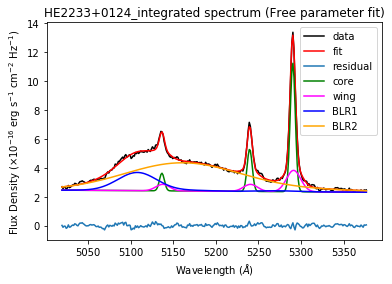

HE0429-0247
[ 1.90813311e+01  1.13321286e+02  1.26398336e+04  8.88638832e+01
 -6.97950983e+00  2.13814498e+01  1.25847944e+04  2.26323699e+02
  2.16995607e+01  6.50351996e-01  1.26506301e+04  4.00302804e+02
  1.53578372e+01  2.06282012e+00  1.26625325e+04  1.55481786e+03
 -7.07760913e+00  5.09272364e+01]


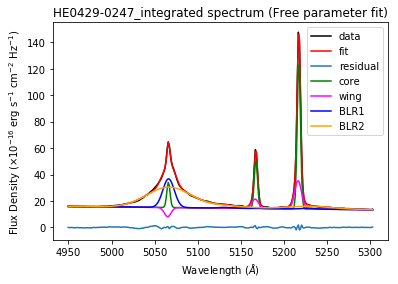

HE0232-0900
[ 7.48239390e+01  7.90364765e+02  1.28678840e+04  1.44786816e+02
 -8.40820495e-01  1.70528717e+02  1.28526173e+04  3.35106331e+02
  1.06598204e+02  1.58144757e+01  1.28837535e+04  2.17436672e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -5.82613563e+01  4.08605442e+02]


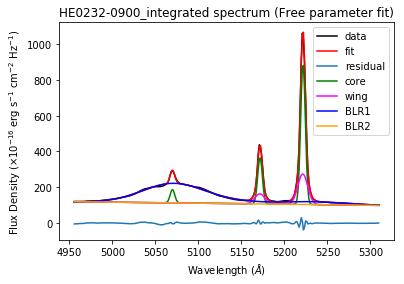

HE2222-0026
[-8.80088070e-01 -3.43725207e+00  1.76854787e+04 -8.43964152e+01
  8.71504314e-01  9.97687140e+00  1.74283517e+04  2.06386682e+02
  6.02617504e+00  6.81850790e-01  1.84961982e+04  1.91423208e+03
 -2.85255021e+00 -3.70582409e-01  2.03778408e+04 -1.14170618e+03
  1.34924066e-01  3.27735317e+00]


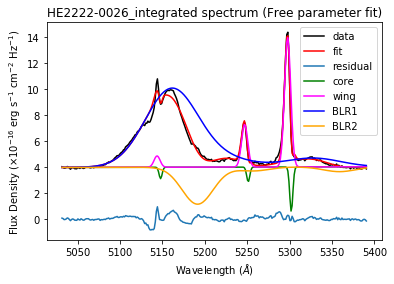

HE0021-1819
[ 4.60567049e+00  4.52592116e+01  1.59577510e+04  7.27816048e+01
  1.27756653e+00  8.98430925e+00  1.58278737e+04  2.99015973e+02
  1.38205937e+00  2.30913778e-01  1.60502336e+04  1.67342263e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -7.87270409e-01  5.71962643e+00]


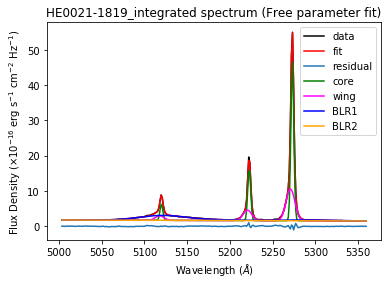

HE0853+0102
[2.67758265e+00 1.47980910e+01 1.57136330e+04 1.02073544e+02
 3.35026407e-01 4.36273891e+00 1.56786658e+04 3.00204526e+02
 1.24410119e+00 7.46265146e-02 1.71500671e+04 1.02477691e+03
 1.84312971e+00 3.27468086e-01 1.53762944e+04 1.48297553e+03
 9.06014938e-03 1.34908089e+00]


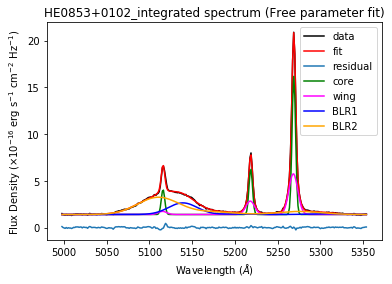

HE1011-0403
[ 5.67086005e+00  3.25295216e+01  1.75356751e+04  9.86960321e+01
  2.40658900e+00  1.71974559e+01  1.73207090e+04  2.55069362e+02
  8.65540589e+00  1.15871188e+00  1.77403559e+04  1.51413826e+03
  2.08855441e+01  2.27368126e+00  1.76593894e+04  7.79737496e+02
 -1.07513461e+01  7.86204666e+01]


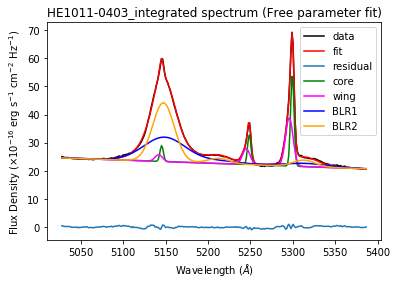

HE0040-1105
[ 7.65553914e+00  9.11019470e+01  1.26437824e+04 -6.89766103e+01
  2.54698182e+00  1.63790536e+01  1.25293124e+04  2.60927051e+02
  7.19846077e+00  1.01997280e+00  1.30246296e+04  1.27898654e+03
  0.00000000e+00  0.00000000e+00  1.25070000e+04  1.00000000e+03
 -1.27590401e+00  1.63340009e+01]


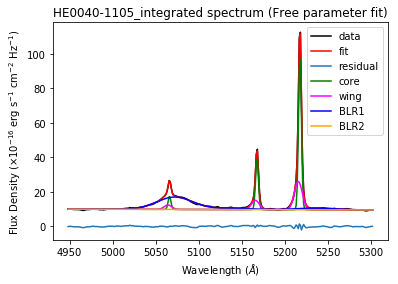

HE0253-1641
[ 2.19008694e+01  2.04057501e+02  9.54555669e+03  1.04814464e+02
  1.12619215e+01  7.01666364e+01  9.30478282e+03  3.63274028e+02
  2.63807383e+01  7.02715413e+00  9.74350201e+03  5.57007056e+02
  1.56104862e+01  3.52848912e+00  9.17439461e+03  1.68324492e+03
 -3.53027426e-01  4.08674058e+01]


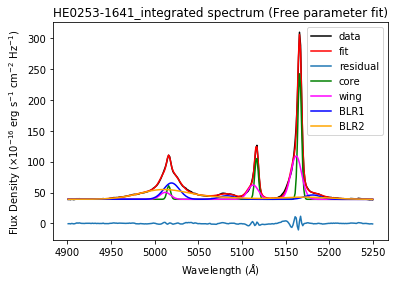

HE0119-0118
[ 2.16562756e+01  8.52899027e+01  1.63495657e+04  1.05449494e+02
  4.82195206e-01  7.03307380e+01  1.61389479e+04  2.37248218e+02
  1.00384037e+01 -3.43517307e-01  1.64942761e+04  8.52444995e+02
  1.10735856e+01  3.89339367e+00  1.63589116e+04  2.21385219e+03
 -1.21587076e+01  7.93149019e+01]


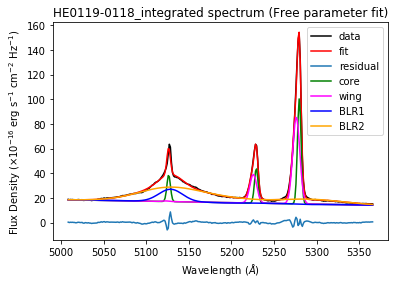

HE0934+0119
[ 9.14921196e+00  4.67811416e+01  1.52081626e+04  6.67900494e+01
  7.97683826e+00  2.57606399e+01  1.51009131e+04 -1.66434132e+02
  3.36071624e+01  4.25214560e+00  1.48527646e+04  9.93942468e+02
 -1.49898973e+01 -1.28442967e+00  1.41453062e+04 -6.29523467e+02
 -5.45725269e+00  4.14111447e+01]


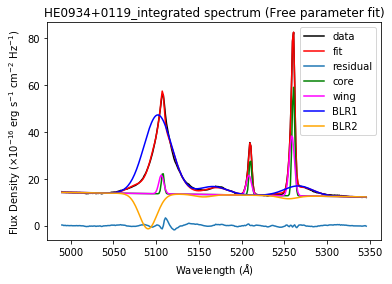

HE1017-0305
[ 4.67596704e+00  4.12015242e+01  1.46709172e+04 -1.01110039e+02
  5.73944831e+03  5.63668441e-01  1.45171524e+04  1.82473478e+03
 -5.72358102e+03  2.13025882e+00  1.45171354e+04  1.82429225e+03
  0.00000000e+00  0.00000000e+00  1.49950000e+04  1.00000000e+03
 -9.24453509e+00  6.25006309e+01]


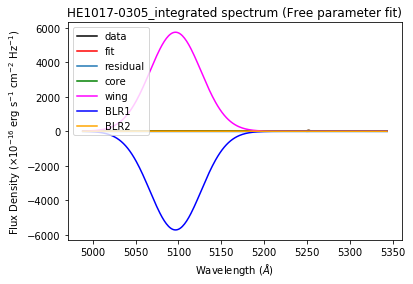

HE0345+0056
[ 1.50820342e+01  1.84635090e+02  9.19861174e+03  1.50727549e+02
  4.49911688e+01  1.23217624e+02  8.86492658e+03  3.87086080e+02
  9.12838215e+01  1.77173697e+01  9.32135464e+03  1.51134970e+03
  2.71752508e+02  2.59855853e+01  9.34371753e+03  3.22881257e+02
 -7.00634970e+00  1.21612292e+02]


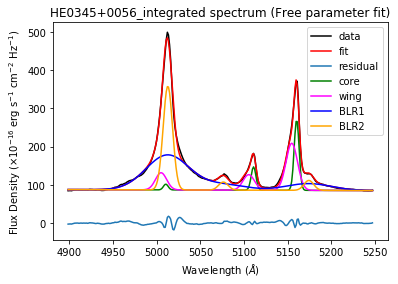

HE0412-0803
[ 9.63078796e+01  1.31101049e+03  1.14767591e+04  8.06890451e+01
  1.94963049e+01  1.82030462e+02  1.14554681e+04  2.52385129e+02
  3.92759195e+01  5.35497351e+00  1.12798069e+04  1.71609546e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -1.02177689e+01  7.79712949e+01]


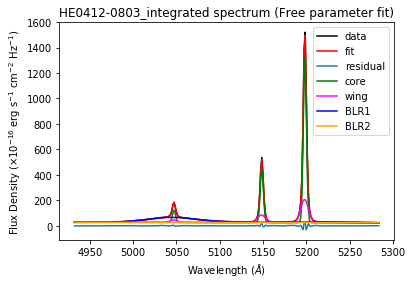

HE0433-1028
[ 1.39812485e+01  8.28324050e+01  1.05903073e+04  1.27329338e+02
  8.43316159e+00  9.07650635e+01  1.02783235e+04  3.34812005e+02
  4.16615571e+01  4.24031399e+00  1.04968767e+04  9.17543474e+02
  2.17083694e+01  5.81120788e+00  1.12100958e+04  2.03032882e+03
 -1.69574479e+01  1.17868419e+02]


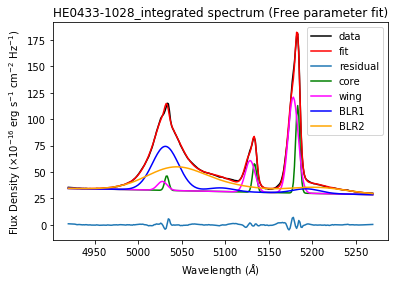

HE1330-1013
[ 4.18649285e+00  1.68252783e+01  6.75090969e+03  7.32935585e+01
  2.42849727e+00  4.01095867e+00  6.60475038e+03  2.28282715e+02
  2.49142554e+00  7.21054254e-01  6.90866030e+03  1.85573297e+03
  7.12928648e+00  1.14484613e+00  6.84018910e+03  6.78431480e+02
 -3.96186205e-01  6.92585439e+00]


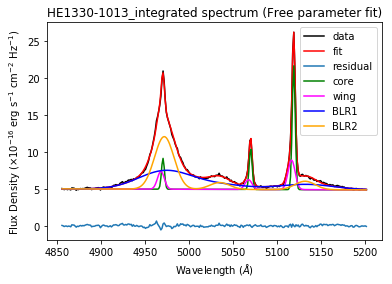

HE1417-0909
[ 7.34105950e+00  1.00819350e+02  1.30842306e+04  6.19418779e+01
  1.61811220e+00  2.08195831e+01  1.30542330e+04  1.83528597e+02
  1.09333917e+01  1.19141293e+00  1.32228958e+04  1.45696255e+03
  0.00000000e+00  0.00000000e+00  1.32000000e+04  1.00000000e+03
 -6.03658570e+00  3.96174523e+01]


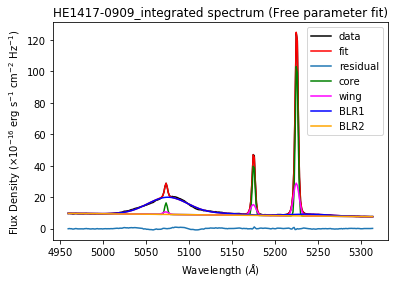

HE0227-0913
[  57.70480588   92.32586196 4796.7804724   138.81870103   30.37511119
    9.12779021 4343.69586833  285.05561208   50.79000224    7.88406971
 4711.74863348 1278.29611166  105.38174348   25.32725692 4919.78096803
  370.23546556   -9.80538502   96.7085911 ]


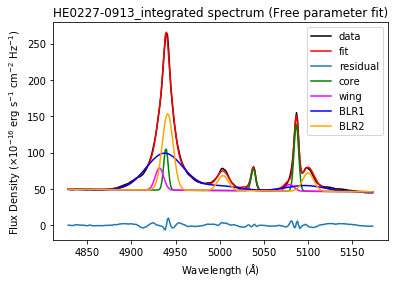

HE1029-1831
[ 2.98728834e+01  9.19125365e+00  1.21264072e+04  7.48930708e+01
  9.08569510e+00  4.05493750e+01  1.19863446e+04  2.17450612e+02
  1.01445664e+01  2.44909606e+00  1.22176546e+04  1.27719009e+03
  4.63719429e+00 -1.07075861e-01  1.29796807e+04  4.36695196e+02
 -2.48178567e-01  1.08099700e+01]


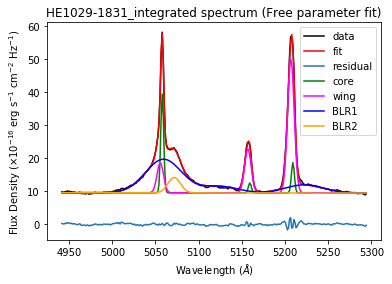

HE2302-0857
[ 1.47670058e+01  1.59872454e+02  1.40486507e+04  9.61489817e+01
  2.55682386e+01  1.86360047e+02  1.41677678e+04  2.66278686e+02
  9.14698288e+00 -9.43256208e-01  1.57133383e+04  8.59316494e+02
  2.41549382e+01  1.02603154e+01  1.30820847e+04  1.97375799e+03
 -2.21123015e+01  1.52917417e+02]


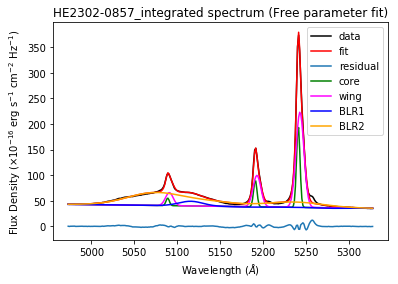

HE1107-0813
[-2.65827932e+00 -6.19202213e+00  1.77772429e+04  8.39490175e+01
  5.71719988e+00  1.12987763e+01  1.76208632e+04  1.97247231e+02
  2.27452150e+01  7.31968708e+00  1.74955976e+04  1.02468434e+03
  1.56572506e+01  2.24521250e+00  1.66600617e+04  2.03705117e+03
 -2.35666268e+01  1.82879305e+02]


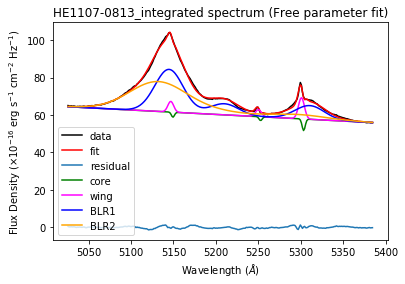

HE2211-3903
[ 8.06613000e+00  4.33130945e+01  1.18609387e+04  6.84378711e+01
  4.97904562e-01  3.85698731e+00  1.17657687e+04  2.12924377e+02
  4.63834961e+00  6.06527314e-01  1.15422989e+04  2.68227940e+03
  0.00000000e+00  0.00000000e+00  1.19140000e+04  1.00000000e+02
 -8.05676497e-01  1.50289317e+01]


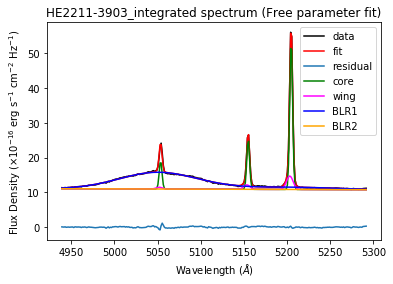

HE1108-2813
[ 2.82131744e+01  4.53394431e+01  7.17061415e+03  6.58174428e+01
  1.17642977e+01  2.83355089e+01  7.05852217e+03  2.31629793e+02
  1.66300290e+01  4.23498357e+00  7.35930623e+03  1.23303241e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -8.36745318e+00  6.25522137e+01]


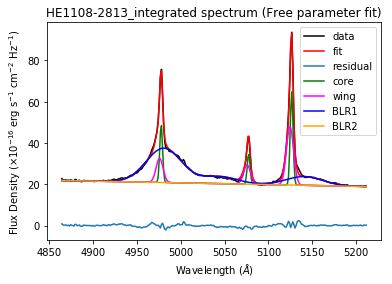

HE1126-0407
[ 1.09718077e+01  1.23857647e+02  1.80353598e+04  1.14120288e+02
  1.93145485e+01  2.31340461e+01  1.77706142e+04  3.45777362e+02
  7.77763558e+01  1.01838335e+01  1.80693846e+04  7.26192585e+02
  5.50800619e+01  1.23264977e+01  1.79837928e+04  1.82428410e+03
 -1.29894093e+01  1.42853620e+02]


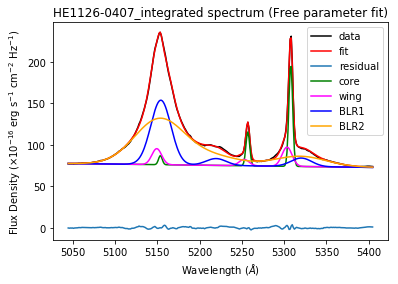

HE0351+0240
[ 1.98122087e+01  3.01116602e+02  1.06388787e+04  7.09058843e+01
  8.35370175e+00  1.81956604e+01  1.06171497e+04  2.42202602e+02
  1.11873395e+01  3.65568647e-01  1.15746041e+04  3.13020493e+02
  2.71246794e+01  2.82176106e+00  1.06632782e+04  1.31849017e+03
 -4.32672748e+00  3.61235910e+01]


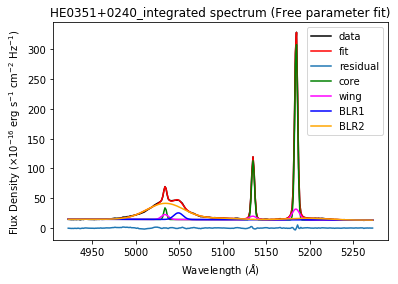

HE0224-2834
[ 7.06631358e+00  7.17607009e+01  1.79848650e+04  1.12566603e+02
  1.47887681e+00  1.86506129e+01  1.79679197e+04  2.72674553e+02
  8.33440099e+00  1.18000118e+00  1.79913637e+04  2.15420848e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.56951646e+00  2.18136230e+01]


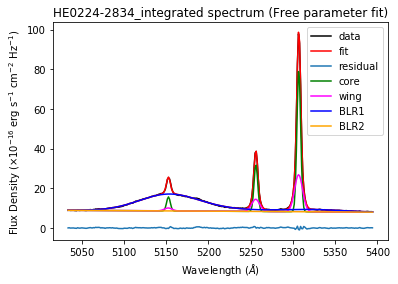

HE1353-1917
[ 5.68672901e+00  4.97602662e+01  1.04988450e+04  9.41287321e+01
  1.38166446e+00  7.75191466e+00  1.03070190e+04  3.48617170e+02
  2.72645823e+00  2.48017631e-02  1.17355658e+04  2.00502053e+03
  2.87539680e+00  8.37412036e-01  8.40951051e+03  1.42534092e+03
 -3.18204569e+00  2.91952192e+01]


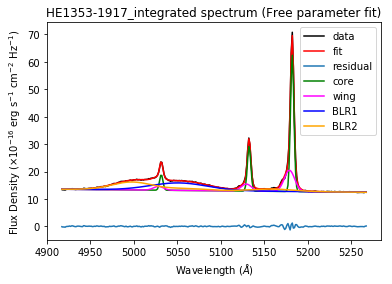

In [4]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692 #,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143,"HE0253-1641":0.031588
    ,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009,"HE0433-1028":0.035550
    ,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986,"HE1029-1831":0.040261
    ,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1330-1013":0.022145,"HE1353-1917":0.035021
    ,"HE1417-0909":0.044,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

#z_remaining = {"HE2128-0221":0.05248,"HE1248-1356":0.01465}
#p_init_of_them = 'HE0108-4743':[1.139,1.5,7176.0,50.0,1.0,3.0,6976.0,200.0,1.0,1.0,7176,1000.0,1.0,1.0,7176,1000.0,-0.001,2.0]
       # ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
       
objs = z.keys()

broad2= {'HE0021-1819':False,'HE0040-1105':False #,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False,'HE0253-1641':True
        ,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True,'HE0433-1028':True
        ,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False,'HE1029-1831':True
        ,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1330-1013':True,'HE1353-1917':True
        ,'HE1417-0909':False,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

asymmetry = {"HE0021-1819":True,"HE0040-1105":True #,"HE0108-4743":dunno,"HE0114-0015":dunno
    ,"HE0119-0118":False,"HE0224-2834":False,"HE0227-0913":False,"HE0232-0900":False,"HE0253-1641":False
    ,"HE0345+0056":False,"HE0351+0240":False,"HE0412-0803":False,"HE0429-0247":False,"HE0433-1028":False
    ,"HE0853+0102":False,"HE0934+0119":True,"HE1011-0403":False,"HE1017-0305":False,"HE1029-1831":False
    ,"HE1107-0813":False,"HE1108-2813":True,"HE1126-0407":False,"HE1330-1013":True,"HE1353-1917":True
    ,"HE1417-0909":False,"HE2211-3903":False,"HE2222-0026":False,"HE2233+0124":False,"HE2302-0857":False}


p_init= {'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
         ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
         ,'HE0119-0118':[22,125,16302,50.0,3,3,16002,100.0,10,1,16302,1000.0,10,1,16302,1500.0,-0.001,0.1]
         ,'HE0224-2834':[7.06899403e+00,7.13458601e+01,1.79847558e+04,1.18000676e+02,1.45515224e+00,1.90068487e+01,1.79693125e+04,2.72340813e+02,8.44672986e+00,9.16885096e-01,1.80245745e+04,2.16641488e+03,0,0,0,0,-2.79613744e+00,2.29434665e+01]  
         ,'HE0227-0913':[15,70,4935,50.0,10,20,4835,100.0,100,20,4935,1000.0,30,10,4935,500.0,-0.001,0.1]
         ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1] 
         ,'HE0253-1641':[21,200,9476,90.0,11,70,9176,200.0,26,7,9476,1000.0,15,3.5,9476,1000.0,-0.001,0.5]
         ,'HE0345+0056':[14,180,9300,155,45,123,9100,400,90,18,9300,1500,270,26,9300,400,-7.0,7.16315181e+00]
         ,'HE0351+0240':[2.19264502e+00,3.70402407e+01,1.06360169e+04,7.72338448e+01,1.10298241e+00,1.50249383e+00,1.06183228e+04,2.77549457e+02,1.52283432e+00,7.54204519e-02,1.15806639e+04,3.17978311e+02,3.47577206e+00,3.51692202e-01,1.06529589e+04,1.34441236e+03,-2.90461186e-01,3.33119886e+00]
         ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
         ,'HE0429-0247':[0.3,1,12602,40.0,7,0.2,12502,500.0,0.1,0.1,12602,460.0,0.1,0.1,12602,1000.0,-0.001,0.1]
         ,'HE0433-1028':[10,100,10665.0,20.0,100,1.0,10465.0,200.0,25,1.0,10665,1000.0,55,0.1,10665,2500.0,-0.1,1.0]
         ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,100.0,0.1,0.1,15600,1000.0,0.1,0.1,15600,1000.0,-0.001,0.1]
         ,'HE0934+0119':[11,47,15101,50.0,7,24,14901,100.0,28,3.0,15101,1000.0,3,1,15101,1000.0,0.001,0.7]
         ,'HE1011-0403':[6,40,17494,60.0,6,6,17250,200.0,20,4,17494,1000.0,5,3,17494,500.0,0.001,0.7]
         ,'HE1017-0305':[4,35,14995,50,2,3,14895,100,16,3,14995,2000,0,0,14995,1000,-0.3,2.0]
         ,'HE1029-1831':[30,9,12078,30.0,5,45,11978,100.0,5,0.1,12078,1000.0,12,2,12078,1000.0,-0.001,0.2]
         ,'HE1107-0813':[5,10,17400,50,20,3,17200,400,8.66709804e-01,3.59444240e-01,1.75395296e+04,9.89119070e+02,8.77384324e-01,7.64366776e-02,1.68588382e+04,2.00171135e+03,-8.35532281e-01,7.28333927e+00]
         ,'HE1108-2813':[28,35,7200.0,50.0,11,28,7000.0,100.0,16,4.2,7200,1000.0,0,0,7200,1000.0,-8.3,60]
         ,'HE1126-0407':[1.00409949e+00,1.34246331e+01,1.80273208e+04,1.24499810e+02,2.46452048e+00,2.86320853e+00,1.77600119e+04,3.51254916e+02,9.96139933e+00,1.30416561e+00,1.80789175e+04,7.18418498e+02,7.31717375e+00,1.77825637e+00,1.79704287e+04,1.77768741e+03,-9.59655619e-01,1.47131358e+01]                                           
         ,'HE1330-1013':[3,12,6643,88,2,2,6435,215,12,2,6643,1500,3,1,6643,616,-1.74500992e-02,2.87685339e-01]
         ,'HE1353-1917':[6,50,10506.0,100.0,3,10,9906.0,350.0,5,1,10506.0,1000.0,5,1,10506.0,1000.0,-0.001,0.002]
         ,'HE1417-0909':[7,100,13200,50.0,1.6,20,13000,100.0,10,1.2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]
         ,'HE2211-3903':[10,42,11914,50.0,2,5,11714,100.0,5,1,11914,1000.0,0,0,11914,100.0,-0.001,0.2]
         ,'HE2222-0026':[2,10,17734.0,50.0,2,0.1,17634.0,300.0,3,1.5,17634,2000.0,3,1,17834,500.0,-0.001,0.002]
         ,'HE2233+0124':[1.22028194e+00,8.90064859e+00,1.69833290e+04,1.62971108e+02,4.50131881e-01,1.47779738e+00,1.70411796e+04,4.92594446e+02,1.25916841e+00,5.70931015e-02,1.52006283e+04,1.41993597e+03,1.88716298e+00,1.10746190e-01,1.83718450e+04,4.09727643e+03,-3.96372168e-01,4.44439203e+00]
         ,'HE2302-0857':[25,220,14058,50,25,50,14258,500,31,15,14058,1500,20,10,14058,1700,-0.9,6.0]}
              
for obj in objs:
    spectroastrometric_script(obj,z[obj],broad2[obj],asymmetry[obj],p_init[obj])              

In [ ]:
1.22028194e+00,8.90064859e+00,1.69833290e+04,1.62971108e+02,4.50131881e-01,1.47779738e+00,1.70411796e+04,4.92594446e+02,1.25916841e+00,5.70931015e-02,1.52006283e+04,1.41993597e+03,1.88716298e+00,1.10746190e-01,1.83718450e+04,4.09727643e+03,-3.96372168e-01,4.44439203e+00